In [1]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import pandas as pd
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.utils import class_weight
import random
from keras import backend as K

Import model

In [2]:
# import keras
from tensorflow.keras.models import load_model

# Specify the path to the saved model file
model_path = r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\models_new\ra_unet_nbr_2.h5"

# Load the model
model = load_model(model_path, compile=False)

Test #1

In [3]:
test_images = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\testing_image\images/*.tif")
image_names.sort()
for img_path in image_names:
      # print(img_path)
    tiff_image = gdal.Open(img_path, 0)
    band7 = tiff_image.GetRasterBand(7).ReadAsArray()
    band8 = tiff_image.GetRasterBand(8).ReadAsArray()
    band9 = tiff_image.GetRasterBand(9).ReadAsArray()

    X = np.stack((band9, band8, band7), axis=-1)
    
    test_images.append(X)

test_images = np.array(test_images)
print(np.mean(test_images))
# normalize
# test_images = test_images / (2**16-1)
# test_images = test_images.astype(int)

# low, high = np.percentile(X, (2, 98))
# test_images = (test_images-low)/(high-low)
print(test_images.shape)

test_masks = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\mask\ps\multi\truth_2\test\images/*.tif")
#"/content/drive/MyDrive/Colab Notebooks/Deep_learning/256/ps/test_threshold_3/images/*.tif"
image_names.sort()
for img_path in image_names:
  #  print(img_path)
    tiff_image = gdal.Open(img_path, 0)
    band1 = tiff_image.GetRasterBand(1).ReadAsArray()
    test_masks.append(band1)

test_masks = np.array(test_masks)
# test_masks = test_masks
# masks = train_masks.astype(int)
print(np.unique(test_masks))

y_test_cat = to_categorical(test_masks, num_classes=4)
y_test_cat = y_test_cat.astype(int)
print(y_test_cat.shape)
print(np.unique(y_test_cat))

test_images_pre = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\pre\testing\images/*.tif")
image_names.sort()
for img_path in image_names:
    # print(img_path)
    tiff_image = gdal.Open(img_path, 0)
    band7 = tiff_image.GetRasterBand(7).ReadAsArray()
    band8 = tiff_image.GetRasterBand(8).ReadAsArray()
    band9 = tiff_image.GetRasterBand(9).ReadAsArray()

    X = np.stack((band9, band8, band7), axis=-1)
    test_images_pre.append(X)

test_images_pre = np.array(test_images_pre)
print(np.mean(test_images_pre))
# normalize
# test_images_pre = test_images / (2**16-1)
# test_images_pre = test_images_pre.astype(int)

# low, high = np.percentile(X, (2, 98))
# test_images_pre = (test_images_pre)/(high-low)
print(test_images_pre.shape)

test_images_nbr = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\mask\ps\NBR\test\images/*.tif")
image_names.sort()
for img_path in image_names:
    # print(img_path)
    tiff_image = gdal.Open(img_path, 0)
    band1 = tiff_image.GetRasterBand(1).ReadAsArray()
    band2 = tiff_image.GetRasterBand(2).ReadAsArray()
    band3 = tiff_image.GetRasterBand(3).ReadAsArray()

    X = np.stack((band1, band2, band3), axis=-1)
    test_images_nbr.append(X)

test_images_nbr = np.array(test_images_nbr)

# test_images_nbr = test_images_nbr / (2**16-1)
# test_images_nbr = test_images_nbr / np.max(test_images_nbr)
test_images_nbr = np.where(test_images_nbr < 0, 0, test_images_nbr)
print(np.mean(test_images_nbr))

C:\Users\wumin\anaconda3\envs\deep_learning\lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


1314.3571367617008
(36, 256, 256, 3)
[0 1 2 3]
(36, 256, 256, 4)
[0 1]
1314.3589101720738
(36, 256, 256, 3)
3.1644802


In [4]:
test_list = [test_images, test_images_pre, test_images_nbr]
# test_list = [test_images, test_images_pre]
# test_list = [test_images]

In [14]:
from sklearn.metrics import classification_report
from sklearn import metrics
import tensorflow as tf
predicted = np.expand_dims(test_images, 0)
prediction = (model.predict(test_list))
print(prediction.shape)
predicted_img = np.argmax(prediction, axis=3)[:,:,:]
y_test_pred = test_masks
# print(y_test.shape)
print(predicted_img.shape)
cm = metrics.confusion_matrix(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print(cm, "\n")
print(classification_report(y_test_pred.reshape(-1), predicted_img.reshape(-1), digits=4))

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=4)
IOU_keras.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Mean IoU = ", IOU_keras.result().numpy())
values = np.array(IOU_keras.get_weights()).reshape(4, 4)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0] + values[2,0] + values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1] + values[2,1] + values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2] + values[1,2] + values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3] + values[1,3] + values[2,3])
print("class1 IoU = ", class1_IoU)
print("class2 IoU = ", class2_IoU)
print("class3 IoU = ", class3_IoU)
print("class4 IoU = ", class4_IoU)

m = tf.keras.metrics.Accuracy()
m.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print('\n', 'Accuracy = ', m.result().numpy())

from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Kappa:", kappa_score)

2/2 [==============================] - 1s 731ms/step
(36, 256, 256, 4)
(36, 256, 256)
[[1583392   54956    1352     542]
 [  19004  258637   70882    2269]
 [   1222   10622  164047   21969]
 [     96      32   14389  155885]] 
              precision    recall  f1-score   support

           0     0.9873    0.9653    0.9762   1640242
           1     0.7977    0.7373    0.7663    350792
           2     0.6544    0.8291    0.7315    197860
           3     0.8628    0.9148    0.8881    170402

    accuracy                         0.9164   2359296
   macro avg     0.8256    0.8616    0.8405   2359296
weighted avg     0.9222    0.9164    0.9181   2359296

Mean IoU =  0.7374911
class1 IoU =  0.9535266
class2 IoU =  0.6211233
class3 IoU =  0.57664955
class4 IoU =  0.7986648

 Accuracy =  0.91635853
Kappa: 0.8301869567086886


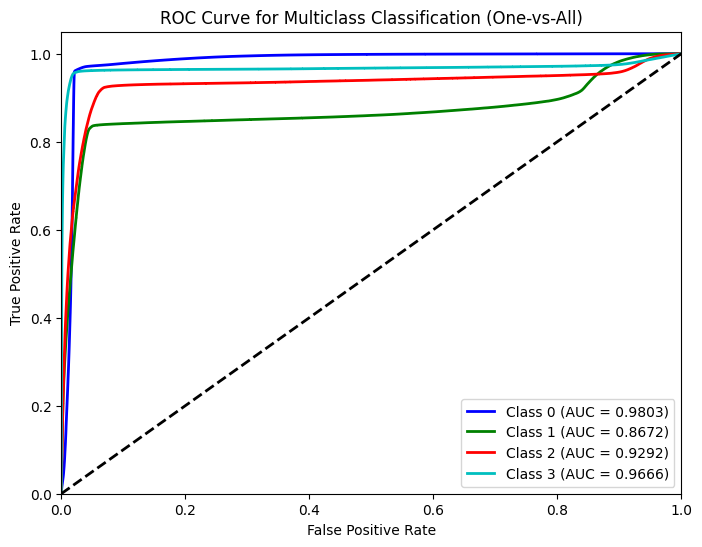

In [49]:
# AUC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
n_classes = 4
confusion_matrix = metrics.confusion_matrix(y_test_pred.reshape(-1), predicted_img.reshape(-1))
y_true = y_test_pred.reshape(-1)
y_true_binary = label_binarize(y_true, classes=np.arange(n_classes))

fpr = [None] * n_classes
tpr = [None] * n_classes
roc_auc = [None] * n_classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], prediction.reshape(2359296, 4)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c']  # Add more colors if needed
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification (One-vs-All)')
plt.legend(loc='lower right')
plt.show()


In [45]:
# print(np.unique(y_test_pred))
# print(np.unique(predicted_img))
print(prediction.reshape(2359296, 4).shape)
print(test_masks.shape)
print(y_true_binary.shape)

(2359296, 4)
(36, 256, 256)
(2359296, 4)


Export

In [ ]:
# Export prediction patches
def createGeotiff(out, data, gt, prj):
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    rasterDS = driver.Create(out, cols, rows, 1, gdal.GDT_Int32)
    rasterDS.SetGeoTransform(gt)
    rasterDS.SetProjection(prj)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(data)
    rasterDS = None

predicted = np.expand_dims(test_list, 0)
prediction = (model.predict(test_list))
print(prediction.shape)
predicted_img = np.argmax(prediction, axis=3)[:,:,:]
print(np.unique(predicted_img))



i = 0
for directory_path in glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\testing_image\images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        out = rf"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\models_new\output\FCN\{i:d}.tif"
        ds = gdal.Open(img_path)
        rows = ds.RasterYSize
        cols = ds.RasterXSize
        bands = ds.RasterCount
        gt = ds.GetGeoTransform()
        prj = ds.GetProjectionRef()

        classification = predicted_img[i].reshape((rows,cols))
        createGeotiff(out,classification,gt,prj)

        i = i+1


Test #2

In [ ]:
test_images = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\testing_image\images/*.tif")
image_names.sort()
for img_path in image_names:
      # print(img_path)
    tiff_image = gdal.Open(img_path, 0)
    band7 = tiff_image.GetRasterBand(7).ReadAsArray()
    band8 = tiff_image.GetRasterBand(8).ReadAsArray()
    band9 = tiff_image.GetRasterBand(9).ReadAsArray()

    X = np.stack((band9, band8, band7), axis=-1)
    
    test_images.append(X)

test_images = np.array(test_images)
print("mean post", np.mean(test_images))
# normalize
# test_images = test_images / (2**16-1)
# test_images = test_images.astype(int)

# low, high = np.percentile(X, (2, 98))
# test_images = (test_images-low)/(high-low)
print(test_images.shape)

test_masks = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\mask\ps\multi\truth_2\test\images/*.tif")
#"/content/drive/MyDrive/Colab Notebooks/Deep_learning/256/ps/test_threshold_3/images/*.tif"
image_names.sort()
for img_path in image_names:
  #  print(img_path)
    tiff_image = gdal.Open(img_path, 0)
    band1 = tiff_image.GetRasterBand(1).ReadAsArray()
    test_masks.append(band1)

test_masks = np.array(test_masks)
# test_masks = test_masks
# masks = train_masks.astype(int)
print(np.unique(test_masks))

y_test_cat = to_categorical(test_masks, num_classes=4)
y_test_cat = y_test_cat.astype(int)
print(y_test_cat.shape)
print(np.unique(y_test_cat))

test_images_pre = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\pre\testing\images/*.tif")
image_names.sort()
for img_path in image_names:
    # print(img_path)
    tiff_image = gdal.Open(img_path, 0)
    band7 = tiff_image.GetRasterBand(7).ReadAsArray()
    band8 = tiff_image.GetRasterBand(8).ReadAsArray()
    band9 = tiff_image.GetRasterBand(9).ReadAsArray()

    X = np.stack((band9, band8, band7), axis=-1)
    test_images_pre.append(X)

test_images_pre = np.array(test_images_pre)
print("mean pre", np.mean(test_images_pre))
# normalize
# test_images_pre = test_images / (2**16-1)
# test_images_pre = test_images_pre.astype(int)

# low, high = np.percentile(X, (2, 98))
# test_images_pre = (test_images_pre)/(high-low)
print(test_images_pre.shape)

In [ ]:
test_list = [test_images, test_images_pre]

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
import tensorflow as tf
predicted = np.expand_dims(test_images, 0)
prediction = (model.predict(test_list))
print(prediction.shape)
predicted_img = np.argmax(prediction, axis=3)[:,:,:]
y_test_pred = test_masks
# print(y_test.shape)
print(predicted_img.shape)
cm = metrics.confusion_matrix(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print(cm, "\n")
print(classification_report(y_test_pred.reshape(-1), predicted_img.reshape(-1), digits=4))

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=4)
IOU_keras.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Mean IoU = ", IOU_keras.result().numpy())
values = np.array(IOU_keras.get_weights()).reshape(4, 4)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0] + values[2,0] + values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1] + values[2,1] + values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2] + values[1,2] + values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3] + values[1,3] + values[2,3])
print("class1 IoU = ", class1_IoU)
print("class2 IoU = ", class2_IoU)
print("class3 IoU = ", class3_IoU)
print("class4 IoU = ", class4_IoU)

m = tf.keras.metrics.Accuracy()
m.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print('\n', 'Accuracy = ', m.result().numpy())
kappa_score = cohen_kappa_score(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Kappa:", kappa_score)